# Improve eddy tracking

The objective of this script is to improve the eddy tracking and remove all the bugs found in the first stage of development. 

In [1]:
# Importing all libraries except trackeddy.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
import time

In [2]:
# Output data path
outputpath='/g/data/v45/akm157/model_output/mom/mom01v5_kds75/output306/'
# Import SSH values to python environment.
ncfile=Dataset(outputpath+'rregionsouthern_ocean_daily_eta_t.nc')
eta=ncfile.variables['eta_t'][:]*100
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean_sub01'][:]
lat=ncfile.variables['yt_ocean_sub01'][:]

In [3]:
# Track eddy script used to update and remove bugs, It should be the same as the trackeddy.py file.
import numpy as np
import numpy.ma as ma
import pylab as plt
from mpl_toolkits.basemap import Basemap

def scan_eddym(ssh,lon,lat,levels,date,areamap,mask='',destdir='',okparm='',basemap=False,diagnostics=False):
    '''
    *************Scan Eddym***********
    Function to identify each eddy using closed contours,
    also this function checks if the elipse adjusted have
    a consistent eccentricity, vorticty and other parameters.
    Usage:
    ssh= Sea Surface Height in cm
    lon,lat=longitude and latitude of your grid.
    levels=where the code will find the closed contours.
    date=date in julian days
    areamap=Section of interest
    mask=Continent mask
    
    Example:
    ssh=Read netCDF4 data with mask or create a mask for your data
    lon=Import your longitude coordinates, if your grid is regular, you can use a linspace instead
    lat=Import your latitude coordinates (same as above).
    levels=List of the levels in which ones you want to find the eddies
    date=Date as Julian Days
    areamap=array([[0,len(lon)],[0,len(lat)]]) Array with the index of your area of interest.
    I used some auxilar functions, each one has his respective author.
    Author: Josue Martinez Moreno, 2017
    '''
    ellipse_path=[]
    contour_path=[]
    shapedata=np.shape(ssh)
    if ssh is ma.masked:
        print 'Invalid ssh data, must be masked'
        return
    if shapedata == [len(lat), len(lon)]:
        print 'Invalid ssh data size, should be [length(lat) length(lon]'
        return
    if np.shape(areamap) == shapedata:
        if np.shape(areamap) == [1, 1] | len(areamap) != len(lat):
            print 'Invalid areamap, using NaN for eddy surface area'
        return
    if len(levels)!= 2:
        print 'Invalid len of levels, please use the function for multiple levels or use len(levels)==2'
        return
    #Saving mask for future post-processing.  

    if mask!='':
        ssh=np.ma.masked_array(ssh, mask)
    sshnan=ssh.filled(np.nan)

    #sshnan=ma.masked_array(okparm, mask=mask[0,:,:])
    #sshnan=sshnan.filled(nan)
    #Obtain the contours of a surface (contourf), this aproach is better than the contour.
    if len(np.shape(lon))== 1 and len(np.shape(lat)) == 1:
        Lon,Lat=np.meshgrid(lon,lat)
    else:
        Lon,Lat=lon,lat
    
    min_x=Lon[0,0]
    min_y=Lat[0,0]
    max_x=Lon[-1,-1]
    max_y=Lat[-1,-1]
    
    if basemap==True:
        fig, ax = plt.subplots(figsize=(10,10))
        m = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='black',lake_color='aqua')
        m.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
        lonm,latm=m(Lon,Lat)
    
        if len(shapedata)==3:
            m.contourf(lonm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                       latm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                    sshnan[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
            plt.show()

        else:
            m.contourf(lonm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                       latm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                    sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
            plt.show()
            
    if len(shapedata)==3:
        CS=plt.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                sshnan[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
    else:
        CS=plt.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
    plt.close()
    CONTS=CS.allsegs[:][:]
    #Loop in contours of the levels defined.
    print CS.levels
    total_contours=0
    eddyn=0
    for ii in range(0,np.shape(CONTS)[0]):
        CONTSlvls=CONTS[ii]
        for jj in range(0,np.shape(CONTSlvls)[0]):
            CONTeach=CONTSlvls[jj]
            if (len(CONTeach[:,0]) | len(CONTeach[:,1])) <= 20:
                #print 'Singular index I cant get an ellipse with this data'
                xx=np.nan
                yy=np.nan
                center=[np.nan,np.nan]
                check=False
            else:
                ellipse = fitEllipse(CONTeach[:,0],CONTeach[:,1])
                center = ellipse_center(ellipse)
                phi = ellipse_angle_of_rotation(ellipse)
                axes = ellipse_axis_length(ellipse)
                R = np.arange(0,2.1*np.pi, 0.1)
                a,b = axes
                #Ellipse coordinates.
                xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
                yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
                #Area of Contours (contarea) and ellipse (ellipsarea)
                contarea=PolyArea(CONTeach[:,0],CONTeach[:,1])
                ellipsarea=PolyArea(xx,yy)
                # Linear Eccentricity check
                eccen=eccentricity(a,b)
                #Record and check how many grid points have land or masked values
                landcount=0
                for ii in range(0,len(CONTeach[:,0])):
                    idxcheck,idycheck=find2d(lon,lat,CONTeach[ii,0],CONTeach[ii,1])
                    idxelipcheck,idyelipcheck=find2d(lon,lat,center[0],center[1])
                    if len(shapedata)==3:
                        if sshnan[date,idycheck,idxcheck]==np.nan:
                            landcount=countzeros+1
                    else:
                        if sshnan[idycheck,idxcheck]==np.nan:
                            landcount=countzeros+1
                if landcount>=len(CONTeach[:,0])/2:
                    #print 'Thisone is land'
                    check=False
                else:
                    if contarea>ellipsarea:
                        if contarea/1.5>ellipsarea:
                            #print 'Removing contour, thisone is really underestimate'
                            check=False
                        else:
                            if ellipsarea < 400 or contarea<400:
                                #print 'Saving contour in path:'
                                check=True
                            else:
                                check=False
                    elif contarea<ellipsarea:
                        if contarea<ellipsarea/1.5:
                            #print 'Removing contour, thisone is really overestimate'
                            check=False
                        elif eccen<0.99 and eccen>0.6:
                            if ellipsarea < 400 or contarea<400:
                            #print 'Saving contour in path:'
                                check=True
                            else:
                                check=False
                        else:
                            #print 'Removing contour, thisone is really underestimate'
                            check=False
                    else:
                        check=False
                if diagnostics == True and  check == True:
                    print("Ellipse parameters")
                    print("center = ",  center)
                    print("angle of rotation = ",  phi)
                    print("axes (a,b) = ", axes)
                    print("Eccentricity = ",eccen)
                    print("Area = ",contarea,ellipsarea)
                if check==True:# or check==False:
                    #Save data each eddy
                    #print ellipse_path
                    ellipse_path.append([xx,yy])
                    contour_path.append([CONTeach[:,0],CONTeach[:,1]])
                    #print shape(contour_path)
                    if eddyn==0:
                        position=center
                        total_eddy=eddyn
                        area=contarea
                        if CS.levels[0] > 0:
                            level=CS.levels[0]
                        else:
                            level=CS.levels[1]
                    else:
                        position=np.vstack((position,center))
                        total_eddy=np.vstack((total_eddy,eddyn))
                        area=np.vstack((area,contarea))
                        if CS.levels[0] > 0:
                            level=np.vstack((level,CS.levels[0]))
                        else:
                            level=np.vstack((level,CS.levels[1]))
                    
                    eddyn=eddyn+1
                if diagnostics == True:
                    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6))
                    if len(shapedata)==3:
                        ax1.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]])
                        cc=ax2.pcolormesh(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                                          vmin=ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]].min()\
                                          ,vmax=ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]].max())
                        cca=ax2.contour(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels,cmap='jet')
                        ax2.clabel(cca, fontsize=9, inline=1)
                    else:
                        cca=ax1.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                        sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
                        ax1.plot(CONTeach[:,0],CONTeach[:,1],'-r')
                        ax2.plot(CONTeach[:,0],CONTeach[:,1],'-r')
                        ax2.pcolormesh(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                        sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],vmin=-20,vmax=20)
                        plt.show()
                        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6))
                        ax1.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]])
                        cc=ax2.pcolormesh(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                                          vmin=ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]].min()\
                                          ,vmax=ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]].max())
                        cca=ax2.contour(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels,cmap='jet')
                        ax2.clabel(cca, fontsize=9, inline=1)
                    ax1.plot(CONTeach[:,0],CONTeach[:,1],'*r')
                    ax1.plot(xx,yy,'-b')
                    ax1.plot(center[0],center[1],'ob')
                    f.subplots_adjust(right=0.8)
                    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
                    f.colorbar(cc, cax=cbar_ax)
                    ax2.plot(CONTeach[:,0],CONTeach[:,1],'-r')
                    ax2.plot(xx,yy,'-b')
                    ax2.plot(center[0],center[1],'ob')
                    #x, y = np.meshgrid(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]])
                    #c = np.ones_like(x)
                    ax2.plot(lon[idxelipcheck],lat[idyelipcheck],'om')
                    #ax2.pcolor(x, y, c, facecolor='none', edgecolor='k')
                    ax2.set_ylim([CONTeach[:,1].min(),CONTeach[:,1].max()])
                    ax2.set_xlim([CONTeach[:,0].min(),CONTeach[:,0].max()])
                    plt.show()
                    plt.close()
            total_contours=total_contours+1
    contour_path=np.array(contour_path)
    ellipse_path=np.array(ellipse_path)
    possition=np.array(position)
    level=np.array(level)
    eddys=dict_eddym(contour_path, ellipse_path,position,area,total_eddy,level)
#    if destdir!='':
#        save_data(destdir+'day'+str(date)+'_one_step_cont'+str(total_contours)+'.dat', variable)
    print "The total of contours was", total_contours
    return eddys
    
def scan_eddyt(ssh,lat,lon,levels,date,areamap,destdir='',okparm='',diagnostics=False):
    '''
    SCAN_EDDY Scan all of the ssh data passed in (will function correctly if data passed in is a subset)
    ssh: ssh cube with nans for land
    lat: A 1D array of double's that gives the latitude for a given index in ssh data , should be equal to size(ssh, 1)
    lon: A 1D array of double's that gives the longitude for a given index in ssh data, should be equal to size(ssh, 2)
    dates: A 1D array of the dates of ssh data, length should be equal to shape(ssh)[0] 
    destdir: destination directory to save eddies
    '''
    #if destdir!='' or os.path.isdir(destdir)==False:
    #    os.makedirs(directory)
    if len(np.shape(ssh))==3:
        if date==0:
            print 'Please change the date to the number of iteratios you want'
    else:
        print 'Please use the other function scan_eddym'
        return
    for tt in range(0,date):
        print "**********Starting iteration ",tt,"**********"
        eddys=scan_eddym(ssh[tt,:,:],lon,lat,levels,tt,areamap,destdir='',okparm=okparm,diagnostics=diagnostics)
        if tt==0:
            eddytd=dict_eddyt(tt,eddys)
        else:
            eddytd=dict_eddyt(tt,eddys,eddytd) 
        print "**********Finished iteration ",tt,"**********"
    if destdir!='':
        save_data(destdir+str(date),eddies)
    return eddytd

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: SSH mean of the Southern Ocean over 10 years
    history: Created 31/07/17
    dimensions(sizes): lon(3600), lat(931), time(1)
    variables(dimensions): float32 Longitude(lon), float32 Latitude(lat), int32 Time(time), float32 SSH_mean(time,lat,lon)
    groups: 

(931, 3600)


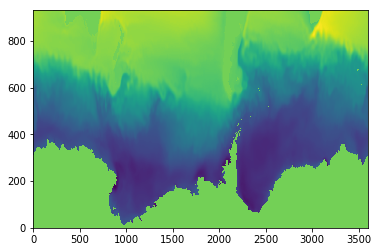

In [4]:
# Import SSH values to python environment.
ncfile=Dataset('/home/156/jm5970/notebooks/traceddy/data.output/meanssh_10yrs_AEXP.nc')
print ncfile

ssh_mean=squeeze(ncfile.variables['SSH_mean'][:])
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['Longitude'][:]
lat=ncfile.variables['Latitude'][:]
print shape(ssh_mean)
pcolormesh(ssh_mean)

In [5]:
for ii in range(0,1):
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    ssha=eta[ii,:,:]-ssh_mean

***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************


In [6]:
areamap=array([[0,len(lon)],[0,len(lat)]])
levels=[10,500]
mask=ma.getmask(eta[0,:,:])

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__delslice__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getslice__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__setslice__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
10


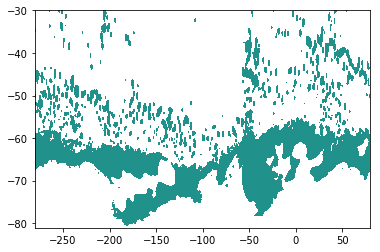

In [7]:
CS=plt.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                ssha[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
print dir(CS.levels)
print CS.levels[0]

In [8]:
###REMASK VALUE EACH TIME STEP
for ii in range(0,1):
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    ssha=eta[ii,:,:]-ssh_mean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddys)
    else:
        eddytd=dict_eddyt(ii,eddys,eddytd) 
#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

# Check and download Aviso dataset 

# Use their code to decide if they select or not the strange eddies (Ask Calem)

***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[10, 500]
The total of contours was 409
('ts', 0)


In [9]:
areamap=array([[0,len(lon)],[0,len(lat)]])
levels=[-500,-13]

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
for ii in range(0,1):
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    print '*****************',ii,'*****************'
    ssha=eta[ii,:,:]-ssh_mean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytdn=dict_eddyt(ii,eddys)
    else:
        eddytdn=dict_eddyt(ii,eddys,eddytd) 

***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[-500, -13]
The total of contours was 252
('ts', 0)


In [10]:
#print eddytd['eddyn_1']['contour']
#mask function V1

##SAVE LEVELIN THE EDDYN DATABASE

def exeddy(eddydt,lat,lon,data,ct,threshold,diagnostics=False):
    '''*************Extract Eddy***********
    Function to extract each eddy using closed contours.
    Usage:
    eddydt= Eddy data structure
    lon,lat=longitude and latitude of your grid.
    levels=Level of the contour
    Example:
    Author: Josue Martinez Moreno, 2017
    '''
    justeddy=zeros(shape(data))
    for key, value in eddydt.items():
        print '*********Removing ',key,'*******'
        level=value['level']
        rct=value['time']
        lonmi=value['contour'][0].min()
        lonma=value['contour'][0].max()
        latmi=value['contour'][1].min()
        latma=value['contour'][1].max()
        mimcx,mimcy=find2d(lon,lat,lonmi,latmi)
        mamcx,mamcy=find2d(lon,lat,lonma,latma)
        loncm=lon[mimcx-threshold:mamcx+1+threshold]
        latcm=lat[mimcy-threshold:mamcy+1+threshold]

        if mimcx==0:
            mimcx=1

        datacm=data[mimcy-threshold:mamcy+1+threshold,mimcx-threshold:mamcx+1+threshold]*1
        
        if level > 0:
            print datacm.max()
            datacm[datacm<=level]=0
            datacm[datacm>=1000]=0
        elif level < 0:
            print datacm.min()
            datacm[datacm>=level]=0
            datacm[datacm<=-1000]=0
            
        if diagnostics==True:
            figure()
            plt.pcolormesh(lon[mimcx-threshold:mamcx+1+threshold],lat[mimcy-threshold:mamcy+1+threshold],datacm)
            plt.colorbar()
            cca=plt.contourf(lon[mimcx-threshold:mamcx+1+threshold],lat[mimcy-threshold:mamcy+1+threshold],datacm,alpha=0.5)
            #plt.clabel(cca, fontsize=10, inline=1,colors='k')
            plot(value['contour'][0],value['contour'][1],'-m')
            plt.show()
            print lon[mimcx-threshold:mamcx+1+threshold].min(),lat[mimcy-threshold:mamcy+1+threshold].min()
            print lon[mimcx-threshold:mamcx+1+threshold].max(),lat[mimcy-threshold:mamcy+1+threshold].max()
            figure()
            print justeddy
           
            pcolormesh(justeddy)
            print justeddy.max(),justeddy.min()
            plt.show()
            plt.close()
            
        justeddy[mimcy-threshold:mamcy+1+threshold,mimcx-threshold:mamcx+1+threshold]=datacm
            
    return justeddy

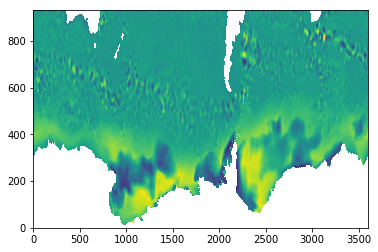

*********Removing  eddyn_249 *******
26.402
*********Removing  eddyn_237 *******
16.2413
*********Removing  eddyn_236 *******
10.5032
*********Removing  eddyn_235 *******
18.0361
*********Removing  eddyn_234 *******
13.7809
*********Removing  eddyn_233 *******
10.5884
*********Removing  eddyn_232 *******
38.3216
*********Removing  eddyn_231 *******
50.7219
*********Removing  eddyn_230 *******
15.4799
*********Removing  eddyn_265 *******
22.361
*********Removing  eddyn_239 *******
14.2391
*********Removing  eddyn_238 *******
14.0684
*********Removing  eddyn_130 *******
29.7854
*********Removing  eddyn_131 *******
11.3734
*********Removing  eddyn_132 *******
11.7827
*********Removing  eddyn_133 *******
19.1593
*********Removing  eddyn_69 *******
12.5893
*********Removing  eddyn_68 *******
18.8332
*********Removing  eddyn_136 *******
12.7829
*********Removing  eddyn_137 *******
10.7525
*********Removing  eddyn_65 *******
11.1525
*********Removing  eddyn_64 *******
36.3335
*********Removin

*********Removing  eddyn_113 *******
11.3665
*********Removing  eddyn_110 *******
12.2259
*********Removing  eddyn_111 *******
18.7431
*********Removing  eddyn_116 *******
13.8506
*********Removing  eddyn_117 *******
13.4806
*********Removing  eddyn_114 *******
12.4255
*********Removing  eddyn_115 *******
12.6633
*********Removing  eddyn_47 *******
15.0362
*********Removing  eddyn_46 *******
11.6187
*********Removing  eddyn_45 *******
14.9277
*********Removing  eddyn_44 *******
14.3649
*********Removing  eddyn_43 *******
13.2199
*********Removing  eddyn_42 *******
10.828
*********Removing  eddyn_41 *******
20.1059
*********Removing  eddyn_40 *******
13.0423
*********Removing  eddyn_49 *******
11.9503
*********Removing  eddyn_48 *******
10.5094
*********Removing  eddyn_156 *******
13.6296
*********Removing  eddyn_157 *******
21.5906
*********Removing  eddyn_154 *******
31.1395
*********Removing  eddyn_225 *******
18.4307
*********Removing  eddyn_202 *******
16.8351
*********Removing  ed

In [11]:
threshold=1
pcolormesh(ssha)
plt.show()
eddysplot=exeddy(eddytd,lat,lon,ssha,0,threshold,diagnostics=False)

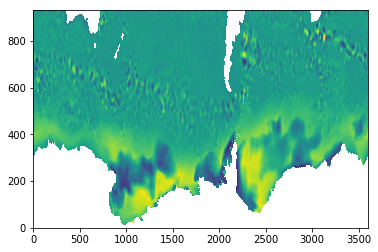

*********Removing  eddyn_130 *******
-16.1724
*********Removing  eddyn_131 *******
-54.792
*********Removing  eddyn_132 *******
-16.8052
*********Removing  eddyn_133 *******
-51.9057
*********Removing  eddyn_69 *******
-18.274
*********Removing  eddyn_68 *******
-17.482
*********Removing  eddyn_136 *******
-14.8329
*********Removing  eddyn_137 *******
-16.1697
*********Removing  eddyn_65 *******
-22.9351
*********Removing  eddyn_64 *******
-28.3645
*********Removing  eddyn_67 *******
-14.465
*********Removing  eddyn_66 *******
-23.2469
*********Removing  eddyn_61 *******
-22.6724
*********Removing  eddyn_60 *******
-36.6278
*********Removing  eddyn_63 *******
-31.0187
*********Removing  eddyn_62 *******
-17.1331
*********Removing  eddyn_145 *******
-14.4555
*********Removing  eddyn_144 *******
-40.4964
*********Removing  eddyn_147 *******
-26.4116
*********Removing  eddyn_146 *******
-53.3296
*********Removing  eddyn_141 *******
-21.1148
*********Removing  eddyn_140 *******
-16.809
***

In [12]:
pcolormesh(ssha)
plt.show()
eddysplotn=exeddy(eddytdn,lat,lon,ssha,0,threshold,diagnostics=False)

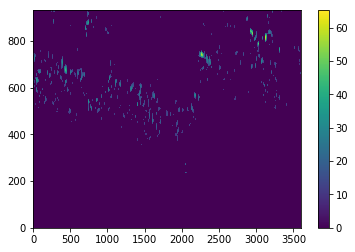

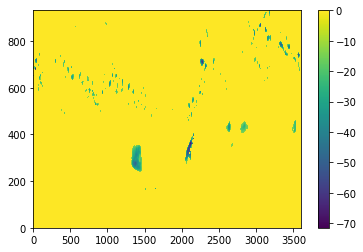

In [13]:
figure()
pcolormesh(eddysplot)
plt.colorbar()
figure()
pcolormesh(eddysplotn)
plt.colorbar()

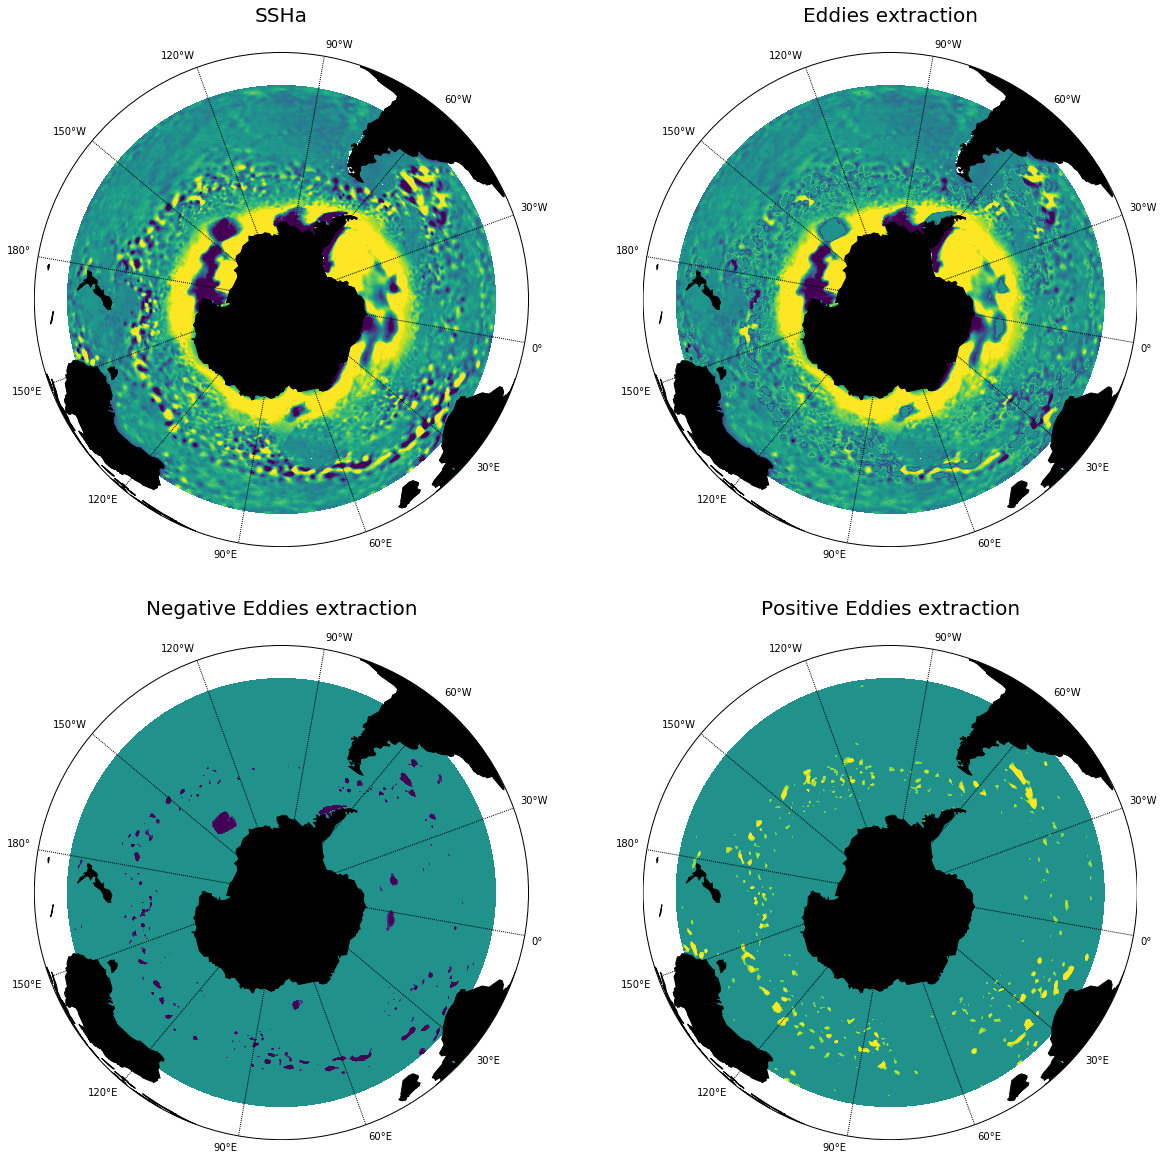

In [14]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(2, 2, figsize=(20,20))

ttl=axes[0,0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[0,1].set_title("Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,1].pcolormesh(lonm,latm,ssha-eddysplot-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,0].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,0])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,0].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
level=8
threshold=1
rct=eddytd['eddyn_1']['time']
data=ssha*1
juesteddy=zeros(shape(data))
lonmi=eddytd['eddyn_1']['contour'][0].min()
lonma=eddytd['eddyn_1']['contour'][0].max()
latmi=eddytd['eddyn_1']['contour'][1].min()
latma=eddytd['eddyn_1']['contour'][1].max()
#print latma, lonma
mimcx,mimcy=find2d(lon,lat,lonmi,latmi)
mamcx,mamcy=find2d(lon,lat,lonma,latma)
loncm=lon[mimcx-threshold:mamcx+1+threshold]
latcm=lat[mimcy-threshold:mamcy+1+threshold]
datacm=data[mimcy-threshold:mamcy+1+threshold,mimcx-threshold:mamcx+1+threshold]
datacm[datacm<=level]=nan
pcolormesh(lon[mimcx-threshold:mamcx+1+threshold],lat[mimcy-threshold:mamcy+1+threshold],datacm)
cca=contourf(lon[mimcx-threshold:mamcx+1+threshold],lat[mimcy-threshold:mamcy+1+threshold],datacm,alpha=0.5)
plt.clabel(cca, fontsize=10, inline=1,colors='k')
plot(eddytd['eddyn_1']['contour'][0],eddytd['eddyn_1']['contour'][1],'-m')
plt.show()        
juesteddy[mimcy-threshold:mamcy+1+threshold,mimcx-threshold:mamcx+1+threshold]=datacm

# Check a and b in the contour and eddy.

In [ ]:
#4,2,3
eddy='eddyn_22'
#print eddytd[eddy]['position']
for ii in range(0,len(eddytd[eddy]['time'])):
    rdd=eddytd[eddy]['time'][ii][0]
    print rdd
    dd="%03d" % ii
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6))
    ax1.pcolormesh(lon,lat,eta[rdd,:,:])
    ax1.plot(eddytd[eddy]['position'][ii,0],eddytd[eddy]['position'][ii,1],'*r')
    ax1.plot(eddytd[eddy]['contour'][ii,0],eddytd[eddy]['contour'][ii,1],'-m')
    c1,c2=find2d(lon,lat,eddytd[eddy]['contour'][ii,0].min(),eddytd[eddy]['contour'][ii,1].min())
    c3,c4=find2d(lon,lat,eddytd[eddy]['contour'][ii,0].max(),eddytd[eddy]['contour'][ii,1].max())
    ax2.contourf(lon[c1-4:c3+4],lat[c2-4:c4+4],eta[rdd,c2-4:c4+4,c1-4:c3+4])
    ax2.plot(eddytd[eddy]['position'][0:ii+1,0],eddytd[eddy]['position'][0:ii+1,1],'-r')
    ax2.plot(eddytd[eddy]['position'][0:ii+1,0],eddytd[eddy]['position'][0:ii+1,1],'*r')
    ax2.plot(eddytd[eddy]['contour'][ii,0],eddytd[eddy]['contour'][ii,1],'-m')
    #print eddytd['eddyn_14']['contour'][:,1]
    #print u[ii,c2:c4,c1:c3]
    #print lonu[c1],lonu[c3],latu[c2],latu[c4]
    #ax2.streamplot(lonu[c1:c3],latu[c2:c4],u[ii,c2:c4,c1:c3],v[rdd,c2:c4,c1:c3])
    #ax2.set_ylim([eddytd[eddy]['contour'][ii,1].min(),eddytd[eddy]['contour'][ii,1].max()])
    #ax2.set_xlim([eddytd[eddy]['contour'][ii,0].min(),eddytd[eddy]['contour'][ii,0].max()])
    ax2.set_title('Day '+str(rdd))
    f.savefig('../output/'+eddy+str(dd)+'.png', bbox_inches='tight')
#eddytd['eddyn_14']
#figure()
#streamplot(lonu,latu,u[ii,:,:],v[ii,:,:], density=1)

In [ ]:
## Calculate amplitud  --> posssible the mean of the ssh.
## Time step parallelization of the code

In [ ]:
areamap=array([[0,len(lon)],[0,len(lat)]])
levels=[10,5000]

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
for ii in range(0,10):
    print ii
    ssha=eta[ii,:,:]-ssh_mean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddys)
    else:
        eddytd=dict_eddyt(ii,eddys,eddytd) 

# Moving in Z

In [15]:
def dict_eddyt(ts,eddys,eddydt=''):
    '''
    Function to create a dictionary with all the eddies.
    All the keys have the following form:
    {eddyn_0:{neddy,time,position,ellipse,contour},eddyn_1:{neddy,time,position,ellipse,contour}}
    Usage:
    
    '''
    print('ts',ts)
    if ts==0 or eddydt=='':
        #Define the variable
        eddydt={'eddyn_'+str(eddys['EddyN'][0][0]):{'neddy':eddys['EddyN'][0],'time':ts,'position':eddys['Position'][0],\
                    'area':eddys['Area'][0],'ellipse':eddys['Ellipse'][0],'contour':eddys['Contour'][0],\
                                                 'level':eddys['Level'][0]}}
        #Append all the new data
        for nn in range(1,len(eddys['EddyN'])):
            eddydt['eddyn_'+str(eddys['EddyN'][nn][0])]={'neddy':eddys['EddyN'][nn],'time':ts,'position':eddys['Position'][nn],\
                    'area':eddys['Area'][nn],'ellipse':eddys['Ellipse'][nn],'contour':eddys['Contour'][nn],\
                                                      'level':eddys['Level'][nn]}
    else:         
        for key, value in eddydt.items():
            print key
            count_new=0
            for nn in range(0,len(eddys['EddyN'])):
                maxlon=eddys['Contour'][nn,0].max()
                maxlone=eddys['Ellipse'][nn,0].max()
                maxlat=eddys['Contour'][nn,1].max()
                maxlate=eddys['Ellipse'][nn,1].max()
                minlon=eddys['Contour'][nn,0].min()
                minlone=eddys['Ellipse'][nn,0].min()
                minlat=eddys['Contour'][nn,1].min()
                minlate=eddys['Ellipse'][nn,1].min()
                area=eddys['Area'][nn]
                if len(np.shape(value['position']))<2:
                    eddyxt0=value['position'][0]
                    eddyyt0=value['position'][1]
                    areae=value['area']
                    timee=value['time']
                else:
                    eddyxt0=value['position'][-1,0]
                    eddyyt0=value['position'][-1,1]
                    areae=value['area'][-1]
                    timee=value['time'][-1]
                eddyxt1=eddys['Position'][nn][0]
                eddyyt1=eddys['Position'][nn][1]
                #except ValueError:
                #    eddyxt0=value['position'][0]
                    #print 'lalal'+str(len(eddyxt0))
                #    eddyyt0=value['position'][1]
                #    eddyxt1=eddys['Position'][nn][0]
                #    eddyyt1=eddys['Position'][nn][1]
#                print dir(value)
                #print value['time'],timee,ts
                if (eddyxt1<=maxlon and eddyxt1>=minlon and eddyyt1<=maxlat and eddyyt1>=minlat) and\
                    (eddyxt0<=maxlon and eddyxt0>=minlon and eddyyt0<=maxlat and eddyyt0>=minlat) and\
                    (areae<=area+area/4 and areae>=area-area/4) and (eddyxt1!=eddyxt0 and eddyyt1!=eddyyt0)\
                    and (int(timee)-ts)>5 and int(timee)!=ts :
                #if (value['neddy']==eddys['EddyN'][nn]):
                    #print 'number',nn,'max',maxlon,'t0',eddyxt0,'t1',eddyxt1,'min',minlon,'area0',areae,'area1',area
                    #print nn,maxlat,eddyyt0,eddyyt1,minlat
                    print "****Tracking Eddy"+str(nn)+"****"
                    number=value['neddy']
                    time=value['time']
                    #print 'Time '+str(time.append(ts))+str(type(time))
                    #print time,ts
                    position=value['position']
                    ellipse=value['ellipse']
                    contour=value['contour']
                    eddydt['eddyn_'+str(number)]={'neddy':number,'time':np.vstack((time,ts)),\
                                            'position':np.vstack((position,eddys['Position'][nn])),\
                                            'area':np.vstack((areae,area)),\
                                            'ellipse':np.vstack((ellipse,eddys['Ellipse'][nn])),\
                                            'contour':np.vstack((contour,eddys['Contour'][nn])),\
                                            'level':np.vstack((level,eddys['Level'][nn]))}
                else:
                    count_new=count_new+1
                    if count_new==len(eddys['EddyN']):
                        print '*****New Eddy*****'
                        eddydt['eddyn_'+str(eddys['EddyN'][nn])]={'neddy':eddys['EddyN'][nn],'time':ts,\
                                            'position':eddys['Position'][nn],'area':eddys['Area'][nn],\
                                            'ellipse':eddys['Ellipse'][nn],\
                                            'contour':eddys['Contour'][nn],'level':eddys['Level'][nn]}
        #eddydt={'eddyn'+str(eddys['EddyN']):{'time':ts,'position':eddys['Position'],'ellipse':eddys['Ellipse']\
#                                    ,'contour':eddys['Contour']}}
    #print eddydt
    return eddydt




def dict_eddyz(ts,ll,minlevel,eddys,eddz='',diagnostics=False):
    '''
    Function to create a dictionary with all the important eddy in Z.
    All the keys have the following form:
    {eddyn_0:{neddy,time,position,ellipse,contour},eddyn_1:{neddy,time,position,ellipse,contour}}
    Usage:
    
    '''
    print('Level analized',ll)
    if ll==minlevel or eddz=='':
        eddz=eddys
    else:         
        count_new=0
        #Always check in the next one because probable we will have more contours if we get closer to 0.
        checklist=[]
        checklist1=[]
        contour=eddz['Contour']
        ellipse=eddz['Ellipse']
        position=eddz['Position']
        area=eddz['Area']
        number=eddz['EddyN']
        level=eddz['Level']
        for nn1 in range(0,len(eddys['EddyN'])):
            maxlon=eddys['Contour'][nn1,0].max()
            maxlone=eddys['Ellipse'][nn1,0].max()
            maxlat=eddys['Contour'][nn1,1].max()
            maxlate=eddys['Ellipse'][nn1,1].max()
            minlon=eddys['Contour'][nn1,0].min()
            minlone=eddys['Ellipse'][nn1,0].min()
            minlat=eddys['Contour'][nn1,1].min()
            minlate=eddys['Ellipse'][nn1,1].min()
            arealb=eddys['Area'][nn1]
            eddyxlb=eddys['Position'][nn1,0]
            eddyylb=eddys['Position'][nn1,1]
            
            #print eddz['Position'][:,0]
            
            for nn0 in range(0,len(eddz['EddyN'])):
                eddyxlt=eddz['Position'][nn0,0]
                eddyylt=eddz['Position'][nn0,1]
                arealt=eddz['Area'][nn0]
                
                if (eddyxlb<=maxlon and eddyxlb>=minlon and eddyylb<=maxlat and eddyylb>=minlat) and\
                (eddyxlt<=maxlon and eddyxlt>=minlon and eddyylt<=maxlat and eddyylt>=minlat) and\
                (arealt>=arealb/1.5 and arealt<=arealb):
                    print 'Contour is growing'
                    
                    
                    #print contour[nn1]
                    contour[nn0]=eddys['Contour'][nn1]
                    ellipse[nn0]=eddys['Ellipse'][nn1]
                    position[nn0]=eddys['Position'][nn1]
                    area[nn0]=eddys['Area'][nn1]
                    level[nn0]=eddys['Level'][nn1]
                    checklist.append(eddys['EddyN'][nn1][0])
                    #print number[nn0][0],eddys['EddyN'][nn1][0]
                    #eddz={'Contour':contour,'Ellipse':ellipse,'Position':position,'Area':area,
                    # 'EddyN':number,'Level':level}
                    if diagnostics==True:
                        plt.figure()
                        plt.plot(eddz['Contour'][nn0,0],eddz['Contour'][nn0,1],'-r')
                        plt.plot(eddys['Contour'][nn1,0],eddys['Contour'][nn1,1],'-b')
                        plt.show()
                        plt.close()
                        print 'eddyN', nn1,nn0
                        print 'eddyt1pos',eddyxlb,eddyylb
                        print 'eddyt0pos',eddyxlt,eddyylt
                        print 'area',arealb, arealt
                elif (eddyxlb<=maxlon and eddyxlb>=minlon and eddyylb<=maxlat and eddyylb>=minlat) and\
                (eddyxlt<=maxlon and eddyxlt>=minlon and eddyylt<=maxlat and eddyylt>=minlat):
                    checklist1.append(eddys['EddyN'][nn1][0])
                
                
                #elif(eddyxlb<=maxlon and eddyxlb>=minlon and eddyylb<=maxlat and eddyylb>=minlat) and\
                #    (eddyxlt<=maxlon and eddyxlt>=minlon and eddyylt<=maxlat and eddyylt>=minlat):
                    # dict_eddym(contour, ellipse, position,area,number,level)
                    # {'Contour':contour,'Ellipse':ellipse,'Position':position,'Area':area,
                    # 'EddyN':number,'Level':level}
#        dict_eddym(contour_path, ellipse_path,position,area,total_eddy,level)
        #print checklist
        #print checklist1
        
        for nn1 in range(0,len(eddys['EddyN'])):
            #print 'tr or fs',(eddys['EddyN'][nn1]!= checklist).all() and (eddys['EddyN'][nn1]!= checklist1).all()
            #print 'eddyn',eddys['EddyN'][nn1]
            if (eddys['EddyN'][nn1]!= checklist).all() and (eddys['EddyN'][nn1]!= checklist1).all():
                #print 'test'
                contour=list(contour)
                contour.append(eddys['Contour'][nn1])
                ellipse=list(ellipse)
                ellipse.append(eddys['Ellipse'][nn1])
                position=np.vstack((position,eddys['Position'][nn1]))
                area=np.vstack((area,eddys['Area'][nn1]))
                level=np.vstack((level,eddys['Level'][nn1]))
                number=np.vstack((number,len(eddz['EddyN'])+1))

        eddz={'Contour':contour,'Ellipse':ellipse,'Position':position,'Area':area,\
              'EddyN':number,'Level':level}
    return eddz

In [16]:
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.ones([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    #print S
    try:
        E, V =  np.linalg.eig(np.dot(np.linalg.inv(S), C))
    except:
        aa=[[  2.46360347e+10,  8.86065412e+09,   3.18685354e+09,  -1.36178743e+08, -4.89784392e+07,   7.52745780e+05],
         [  8.86065412e+09,   3.18685354e+09,   1.14619832e+09,  -4.89784392e+07, -1.76157812e+07,   2.70735119e+05],
         [  3.18685354e+09,   1.14619832e+09,   4.12248210e+08, -1.76157812e+07, -6.33578186e+06,   9.73738194e+04],
         [ -1.36178743e+08,  -4.89784392e+07,  -1.76157812e+07,   7.52745780e+05, 2.70735119e+05,  -4.16090533e+03],
         [ -4.89784392e+07,  -1.76157812e+07,  -6.33578186e+06,   2.70735119e+05, 9.73738194e+04,  -1.49652765e+03],
         [  7.52745780e+05,   2.70735119e+05,   9.73738194e+04,  -4.16090533e+03, -1.49652765e+03,   2.30000000e+01]]
        E, V =  np.linalg.eig(np.dot(np.linalg.inv(aa), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

In [17]:
import scipy.linalg as scl

print dir(scipy.linalg)
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    print 'New Loop'
    print shape(S)
    print det(S)
    print 'Normal'
    print S,C
    print 'Inv'
    print scl.inv(S),C
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

NameError: name 'scipy' is not defined

tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
minlevel=5
maxlevel=40
step=0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel-step,maxlevel+step,step)):
        levels=[ll,500]
        print ll
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddz)
    else:
        eddytd=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

#Check and download Aviso dataset 

#Use their code to decide if they select or not the strange eddies (Ask Calem)

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
minlevel=5
maxlevel=30
step=0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel-step,maxlevel+step,step)):
        levels=[ll,500]
        print ll
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddz)
    else:
        eddytd=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

# Check and download Aviso dataset 

# Use their code to decide if they select or not the strange eddies (Ask Calem)

30.0
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[30.0, 500]
The total of contours was 96
('Level analized', 30.0)
29.5
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
[29.5, 500]
The total of contours was 105
('Level analized', 29.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour

[26.0, 500]
The total of contours was 116
('Level analized', 26.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
25.5
***************** 0 *****************
***************** 0 *****************
***************** 0 *****************
***************** 0 ***************

[22.5, 500]
The total of contours was 143
('Level analized', 22.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

[19.5, 500]
The total of contours was 184
('Level analized', 19.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

[17.0, 500]
The total of contours was 234
('Level analized', 17.0)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

[14.5, 500]
The total of contours was 268
('Level analized', 14.5)
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Contour is growing
Co

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
minlevel=10
maxlevel=20
step=0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel-step,maxlevel+step,step)):
        levels=[ll,500]
        print ll
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytd1=dict_eddyt(ii,eddz)
    else:
        eddytd1=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

# Check and download Aviso dataset 

# Use their code to decide if they select or not the strange eddies (Ask Calem)

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
minlevel=5
maxlevel=10
step=0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel-step,maxlevel+step,step)):
        levels=[ll,500]
        print ll
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytd2=dict_eddyt(ii,eddz)
    else:
        eddytd2=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

# Check and download Aviso dataset 

# Use their code to decide if they select or not the strange eddies (Ask Calem)

In [ ]:
threshold=1
pcolormesh(ssha)
plt.show()
eddysplot=exeddy(eddytd,lat,lon,ssha,0,threshold,diagnostics=False)
eddysplot1=exeddy(eddytd1,lat,lon,ssha,0,threshold,diagnostics=False)
eddysplot2=exeddy(eddytd2,lat,lon,ssha,0,threshold,diagnostics=False)

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(1, 3, figsize=(20,20))

ttl=axes[0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1].pcolormesh(lonm,latm,eddysplot1,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[2].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[2])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[2].pcolormesh(lonm,latm,eddysplot2,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(1, 3, figsize=(20,20))

ttl=axes[0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[2].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[2])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[2].pcolormesh(lonm,latm,ssha-eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
tic = time.clock()
areamap=array([[0,len(lon)],[0,len(lat)]])

mask=ma.getmask(eta[0,:,:])

###REMASK VALUE EACH TIME STEP
minlevel=-10
maxlevel=-30
step=-0.5
for ii in range(0,1):
    for ll in np.flipud(np.arange(minlevel,maxlevel+step,step)):
        levels=[-500,ll]
        print ll
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        print '*****************',ii,'*****************'
        ssha=eta[ii,:,:]-ssh_mean
        eddies=scan_eddym(ssha,lon,lat,levels,ii,areamap,mask=mask,destdir='',okparm='',diagnostics=False)
        #print eddies['Level']
        if ll == maxlevel:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,diagnostics=False)
        else:
            eddz = dict_eddyz(ii,ll,minlevel,eddies,eddz,diagnostics=False)
    if ii==0:
        eddytdn=dict_eddyt(ii,eddz)
    else:
        eddytdn=dict_eddyt(ii,eddz,eddytd) 

toc = time.clock()
print toc-tic

#Look in time and probably 
#Check rho_0 Teos10 package gsw
#plot 100m velocity over the ssh field

# Check and download Aviso dataset 

# Use their code to decide if they select or not the strange eddies (Ask Calem)

In [ ]:
threshold=1
pcolormesh(ssha)
plt.show()
eddysplotn=exeddy(eddytdn,lat,lon,ssha,0,threshold,diagnostics=False)

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(1, 3, figsize=(20,20))

ttl=axes[0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[1].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[2].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[2])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[2].pcolormesh(lonm,latm,ssha-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [ ]:
Lon,Lat=np.meshgrid(lon,lat)

fig, axes = plt.subplots(2, 2, figsize=(20,20))

ttl=axes[0,0].set_title("SSHa", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,0])
lonm,latm=map(Lon,Lat)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,0].pcolormesh(lonm,latm,ssha,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()

ttl=axes[0,1].set_title("Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[0,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[0,1].pcolormesh(lonm,latm,ssha-eddysplot-eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,0].set_title("Negative Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,0])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,0].pcolormesh(lonm,latm,eddysplotn,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

ttl=axes[1,1].set_title("Positive Eddies extraction", fontsize=20)
ttl.set_position([.5, 1.05])
map = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='c',ax=axes[1,1])
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
axes[1,1].pcolormesh(lonm,latm,eddysplot,vmin=-20,vmax=20)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()

f.savefig('../output/eddy_removal.png', bbox_inches='tight')

plt.show()